# MLP Multivariate

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import keras

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.activations import sigmoid
from keras.models import Sequential
from keras import models, layers, backend, optimizers
from keras.layers import Dropout, BatchNormalization
from keras.callbacks import EarlyStopping

import time
from math import sqrt

In [3]:
# read the dataframe and assign the time column as the index values of the dataframe
file = "./dataset.csv"
df = pd.read_csv(file, index_col='Date', parse_dates=True)
df.head()

,AUD,EUR,NZD,GBP,BRL,CAD,CNY,DKK,HKD,INR,...,CHF,TWD,THB,VEB,gdpGBP,gdpUSD,GBR_Value,USA_Value,liborUSD,liborGBP
Date,,,,,,,,,,,,,,,,,,,,,
2001-10-01,0.4923,0.9159,0.4068,1.4785,2.687,1.5794,8.2768,8.1151,7.7992,48.03,...,1.6196,34.60,44.59,0.7435,100.102000,99.250410,-1.864082,-3.311788,2.597400,4.673300
2001-10-02,0.4953,0.9149,0.4055,1.4618,2.700,1.5696,8.2768,8.1267,7.7993,48.03,...,1.6227,34.62,44.70,0.7430,100.097058,99.246839,-1.871180,-3.319114,2.578500,4.625553
2001-10-03,0.4971,0.9181,0.4093,1.4756,2.729,1.5688,8.2768,8.0968,7.7995,47.96,...,1.6157,34.61,44.69,0.7432,100.092116,99.243267,-1.878278,-3.326440,2.559599,4.577806
2001-10-04,0.4975,0.9141,0.4084,1.4774,2.729,1.5680,8.2768,8.1339,7.7998,48.04,...,1.6248,34.61,44.69,0.7430,100.087175,99.239696,-1.885376,-3.333766,2.540699,4.530060
2001-10-05,0.5060,0.9168,0.4135,1.4795,2.754,1.5626,8.2768,8.1115,7.7999,48.05,...,1.6204,34.60,44.77,0.7433,100.082233,99.236125,-1.892474,-3.341092,2.521798,4.482313


In [4]:
# extract columns
df.columns

Index(['AUD', 'EUR', 'NZD', 'GBP', 'BRL', 'CAD', 'CNY', 'DKK', 'HKD', 'INR',
       'JPY', 'MYR', 'MXN', 'NOK', 'ZAR', 'SGD', 'KRW', 'LKR', 'SEK', 'CHF',
       'TWD', 'THB', 'VEB', 'gdpGBP', 'gdpUSD', 'GBR_Value', 'USA_Value',
       'liborUSD', 'liborGBP'],
      dtype='object')

In [5]:
# move the response variable to the end of the dataframe
df = df[['AUD', 'EUR', 'NZD', 'BRL', 'CAD', 'CNY', 'DKK', 'HKD', 'INR',
       'JPY', 'MYR', 'MXN', 'NOK', 'ZAR', 'SGD', 'KRW', 'LKR', 'SEK', 'CHF',
       'TWD', 'THB', 'VEB', 'gdpGBP', 'gdpUSD', 'GBR_Value', 'USA_Value',
       'liborGBP', 'liborUSD', 'GBP']]
df.tail()

,AUD,EUR,NZD,BRL,CAD,CNY,DKK,HKD,INR,JPY,...,TWD,THB,VEB,gdpGBP,gdpUSD,GBR_Value,USA_Value,liborGBP,liborUSD,GBP
Date,,,,,,,,,,,,,,,,,,,,,
2024-06-11,1.515841,0.931735,1.631062,5.353400,1.376758,7.253578,6.949577,7.811661,83.638895,157.346569,...,32.404316,36.767378,3.640488e+06,99.75476,100.4912,-2.506553,-2.901892,5.31892,5.44784,0.786051
2024-06-12,1.492555,0.922254,1.608355,5.391727,1.369258,7.238321,6.878984,7.808406,83.461257,155.873209,...,32.208627,36.463539,3.639495e+06,99.75476,100.4912,-2.506553,-2.901892,5.31892,5.44784,0.778792
2024-06-13,1.505802,0.929766,1.620082,5.378350,1.374745,7.251951,6.936063,7.810498,83.541961,156.766264,...,32.372222,36.745992,3.640529e+06,99.75476,100.4912,-2.506553,-2.901892,5.31892,5.44784,0.783488
2024-06-14,1.511768,0.934700,1.628520,5.356692,1.373957,7.255747,6.973394,7.811850,83.550696,157.270753,...,32.380359,36.681078,3.637539e+06,99.75476,100.4912,-2.506553,-2.901892,5.31892,5.44784,0.788411
2024-06-15,1.512134,0.933782,1.627663,5.377250,1.374093,7.255770,6.971830,7.810608,83.564196,157.390599,...,32.377418,36.684607,3.637257e+06,99.75476,100.4912,-2.506553,-2.901892,5.31892,5.44784,0.788277


In [6]:
# scale the multivariate data for the network approximation
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)
X = pd.DataFrame(df_scaled, columns=df.columns)
X.tail()

,AUD,EUR,NZD,BRL,CAD,CNY,DKK,HKD,INR,JPY,...,TWD,THB,VEB,gdpGBP,gdpUSD,GBR_Value,USA_Value,liborGBP,liborUSD,GBP
6121,0.911974,0.150261,0.879665,0.870634,0.660859,0.541735,0.574207,0.725418,0.999324,0.989093,...,0.634959,0.501066,0.000008,0.844972,0.859716,0.586449,0.709985,0.883529,0.99941,0.058592
6122,0.891226,0.138223,0.863366,0.879378,0.650083,0.534923,0.556499,0.702529,0.995393,0.971240,...,0.609499,0.482426,0.000008,0.844972,0.859716,0.586449,0.709985,0.883529,0.99941,0.053432
6123,0.903029,0.147761,0.871784,0.876326,0.657967,0.541009,0.570817,0.717240,0.997179,0.982061,...,0.630784,0.499754,0.000009,0.844972,0.859716,0.586449,0.709985,0.883529,0.99941,0.056770
6124,0.908345,0.154025,0.877840,0.871385,0.656835,0.542703,0.580182,0.726747,0.997373,0.988174,...,0.631842,0.495772,0.000008,0.844972,0.859716,0.586449,0.709985,0.883529,0.99941,0.060270
6125,0.908671,0.152860,0.877225,0.876075,0.657030,0.542714,0.579789,0.718014,0.997671,0.989626,...,0.631460,0.495988,0.000008,0.844972,0.859716,0.586449,0.709985,0.883529,0.99941,0.060175


In [7]:
def CreateLaggedSequence(data, lag):
    # make two lists for PredictorSequences and ResponseVariables
    PredictorSequences, ResponseVariables = list(), list()
    for i in range(len(data)):
        # mark the range of the sequence
        end_i = i + lag
        # check when the data ends
        if end_i+1 > len(data):
            # stop sequence creation
            break
        # get the predictors and responses
        PredictorSequence = data[i:end_i]
        ResponseVariable = data[end_i, -1]
        # append them to the lists
        PredictorSequences.append(PredictorSequence)
        ResponseVariables.append(ResponseVariable)
        # print(end_i)
    return np.array(PredictorSequences), np.array(ResponseVariables)

In [8]:
# Define input parameters
NumberOfFeatures = len(df.columns)
lag = 5
# create the lagged values for the series (5 lags)
np_X = np.array(X)
X, y = CreateLaggedSequence(np_X, lag)
# Reshape it for the process
X = X.reshape(X.shape[0], X.shape[1]*X.shape[2])
X.shape, y.shape

((6121, 145), (6121,))

In [9]:
# split the train and test sets (last 50 observation spared for the test)
x_train, x_test = X[:-50], X[-50:]
y_train, y_test = y[:-50], y[-50:]
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((6071, 145), (50, 145), (6071,), (50,))

In [10]:
# define new activation function
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

from keras.utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'swish': Activation(swish)})

In [11]:
# create a start point for timer
start = time.time()

# design the model
backend.clear_session()
model = models.Sequential()

model.add(layers.Dense(3*2**10, activation='swish', kernel_initializer='he_uniform', input_shape = (x_train.shape[1],)))
# model.add(BatchNormalization())
model.add(layers.Dense(3*2**8, activation='swish', kernel_initializer='he_uniform'))
# model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(layers.Dense(3*2**6, activation='swish', kernel_initializer='he_uniform'))
# model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(layers.Dense(3*2**4, activation='swish', kernel_initializer='he_uniform'))
# model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(layers.Dense(3*2**2, activation='swish', kernel_initializer='he_uniform'))
# model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(layers.Dense(3*2**0, activation=tf.keras.backend.sin, kernel_initializer='he_uniform'))
# model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(layers.Dense(1, activation='swish'))

# compile the model
model.compile(optimizer = optimizers.Adam(learning_rate=0.00007), loss = 'mse', metrics = ['mae'])
#get the summary of the model
model.summary()

################################################################################

# fit the model
history = model.fit(x_train, y_train, 
            epochs = 2**10, 
            batch_size = 3892, 
            validation_split = 0.20, # sparing validation data from the training data
            verbose = 1, 
            callbacks=[EarlyStopping(monitor='val_mae', patience=2**6, restore_best_weights = True)])  # restore the best values

#evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print('test_acc:', test_acc)

# end the timer and print the total time passed
end = time.time()
print("Total time:", end-start, "seconds")

/Users/user/RepoGithub/DSP-Forecasting-Reer/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 3072)           │       448,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 768)            │     2,360,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 192)            │       147,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 48)             │         9,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 12)             │           588 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            39 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,966,119 (11.31 MB)

 Trainable params: 2,966,119 (11.31 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1024
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 432ms/step - loss: 0.3948 - mae: 0.5599 - val_loss: 0.0282 - val_mae: 0.1591
Epoch 2/1024
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - loss: 0.3249 - mae: 0.5194 - val_loss: 0.0032 - val_mae: 0.0479
Epoch 3/1024
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - loss: 0.2950 - mae: 0.4675 - val_loss: 0.0043 - val_mae: 0.0577
Epoch 4/1024
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - loss: 0.2481 - mae: 0.4334 - val_loss: 0.0146 - val_mae: 0.1088
Epoch 5/1024
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - loss: 0.2518 - mae: 0.4472 - val_loss: 0.0090 - val_mae: 0.0841
Epoch 6/1024
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - loss: 0.2454 - mae: 0.4364 - val_loss: 0.0021 - val_mae: 0.0404
Epoch 7/1024
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - loss: 0.2448 - mae: 0.4277 - val_loss: 0.0013 - val_mae: 0.0292
Epoch 8/1024
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - loss: 0.2352 - mae: 0.4165 - val_loss: 0.0024 - val_mae: 0.0436
Epoch 9/1024
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - lo

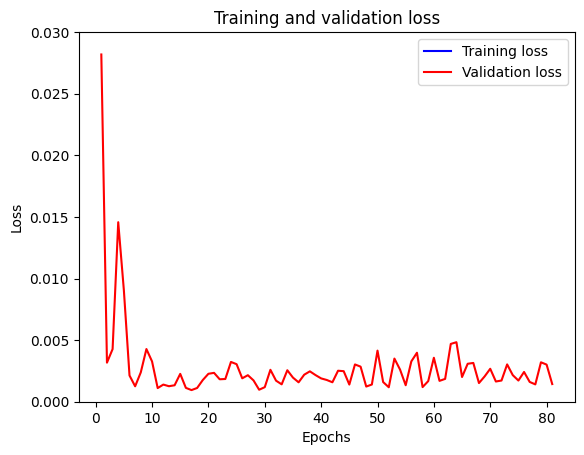

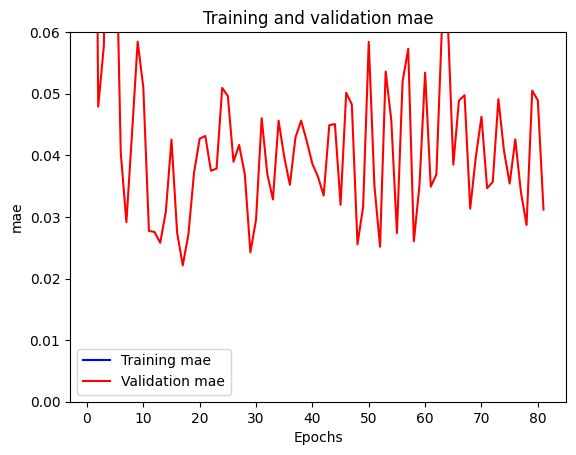

In [12]:
# get the history of the fitting process
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
mae_values = history_dict['mae']
val_mae_values = history_dict['val_mae']
epochs = range(1, len(history_dict['mae']) + 1)
# plot the training and validation losses
plt.plot(epochs, loss_values, label = 'Training loss', color='blue')
plt.plot(epochs, val_loss_values, label = 'Validation loss', color='red')
plt.ylim(0,0.03)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
# plot the training and validation mae (mean absolute error)
plt.plot(epochs, mae_values, label = 'Training mae', color='blue')
plt.plot(epochs, val_mae_values, label = 'Validation mae', color='red')
plt.ylim(0,0.06)
plt.title('Training and validation mae')
plt.xlabel('Epochs')
plt.ylabel('mae')
plt.legend()
plt.show()

In [13]:
# predict the model on the test set (scaled)
yhat_scaled = model.predict(x_test, verbose=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


In [14]:
# insert the scaled predictions into the scaled dataframe
df_scaled[-len(yhat_scaled):] = yhat_scaled
# invert the scaled data (with the predictions) back to real values
df_inverted = scaler.inverse_transform(df_scaled)
# convert the data to dataframe
df_invertedDF = pd.DataFrame(df_inverted, columns=df.columns, index=df.index)

In [15]:
# convert the predictions series
predictions = df_invertedDF.iloc[-len(yhat_scaled):, -1]
# extract the actual values
actuals = df['GBP'][-50:]

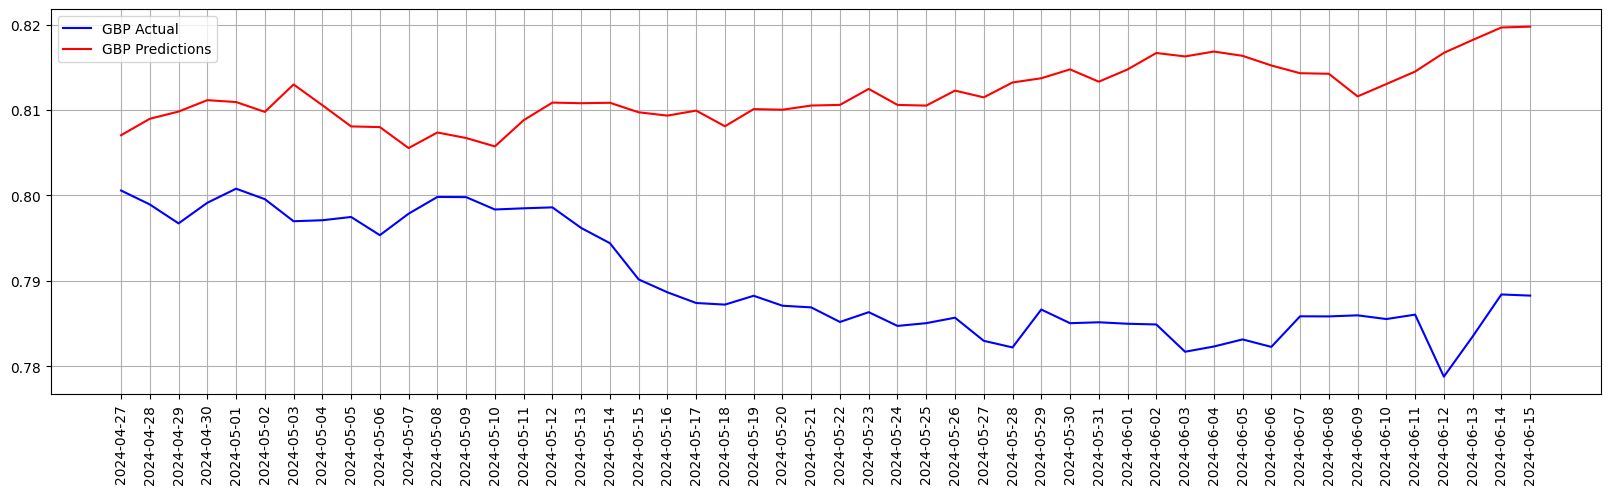

Test RMSE: 0.02370
Test MSE: 0.00056
Test MAE: 0.02188
Test MAPE: 2.77951


In [16]:
# evaluate forecasts and plot them together
plt.figure(figsize=(20,5))
plt.plot(actuals.index, actuals, color='blue')
plt.plot(actuals.index, predictions, color='red')
plt.legend(('GBP Actual', 'GBP Predictions'))
plt.xticks(actuals.index, rotation=90)
plt.grid(True)
plt.show()

# Calculate performance metrics
mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
rmse = sqrt(mse)

print(f'Test RMSE: {rmse:.5f}')
print(f'Test MSE: {mse:.5f}')
print(f'Test MAE: {mae:.5f}')
print(f'Test MAPE: {mape:.5f}')